- Read HSI csv files and observation summary xls file 
- Validate whether they match well
- Calculate mean emission by platform
- Export summary to one csv file

In [1]:
import os
from glob import glob
from itertools import chain
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ast import literal_eval
from sklearn.metrics.pairwise import haversine_distances
from math import radians
from matplotlib.ticker import FuncFormatter, AutoMinorLocator

In [2]:
from matplotlib import rcParams
font_size = 17
rcParams['axes.titlesize'] = font_size - 1
rcParams['axes.titleweight'] = 'bold'
rcParams['axes.labelsize'] = font_size - 2
rcParams['xtick.labelsize'] = font_size - 2
rcParams['ytick.labelsize'] = font_size - 2
rcParams['legend.fontsize'] = font_size
rcParams['figure.titlesize'] = font_size 
rcParams['figure.titleweight'] = 'bold'

## Read data

In [3]:
df = pd.read_excel('../data/landfills_hyper_obs.xlsx', sheet_name='Main')

# remove space at end
df['name'] = df['name'].str.strip()

In [4]:
df_any_plume = df[(df['plume(emit)'] > 0) | (df['plume(enmap)'] > 0) | (df['plume(emit)'] > 0)]

In [5]:
def distance(row):
  location1_radian = [radians(_) for _ in [row['latitude'], row['longitude']]]
  location2_radian = [radians(_) for _ in [row['latitude_imeo'], row['longitude_imeo']]]
  result = haversine_distances([location1_radian, location2_radian])
  result = result * 6371000/1000  # multiply by Earth radius to get kilometers

  return result[0][1]

df_any_plume[~df_any_plume['name_imeo'].isna()].apply(distance, axis=1)

0      2.469481
2      0.446089
8      0.449981
9      0.000000
14     0.561375
17     1.004246
18     2.024497
24     0.616425
27     0.293877
36     0.122080
37    32.045020
38     0.410876
40     1.435000
41     0.378171
43     1.247128
48     6.756630
56     0.373522
58     0.389182
65     0.505175
67     3.761195
69     0.731854
72     0.671270
75     0.492830
78     0.771025
dtype: float64

In [6]:
data_dir = '../data/Hyper_TROPOMI_landfill/'

filelist = list(chain(*[glob(os.path.join(data_dir, '**', '*csv'), recursive=True)]))

df_hyper = pd.concat((pd.read_csv(f, converters={'wind_source_all': literal_eval, 'wind_speed_all': literal_eval,
       'wind_direction_all': literal_eval}) for f in filelist), ignore_index=True)

# # add shape error
# df_hyper['emission_uncertainty'] = np.sqrt(df_hyper['emission_uncertainty']**2+(df_hyper['emission']*0.05)**2)
# add percentage error
df_hyper['emission_uncertainty(%)'] = df_hyper['emission_uncertainty']/df_hyper['emission']*100
df_hyper['emission_fetch_uncertainty(%)'] = df_hyper['emission_fetch_uncertainty']/df_hyper['emission_fetch']*100

# convert units from kg/h to t/h
df_hyper['emission'] = df_hyper['emission']/1e3
df_hyper['emission_fetch'] = df_hyper['emission_fetch']/1e3

df_emiss = df_hyper.groupby(['country', 'name', 'platform'], as_index=False)\
    .agg({'plume_longitude':'mean', 'plume_latitude':'mean',
          'emission':'mean', 'emission_uncertainty(%)': 'mean',
          'emission_fetch':'mean', 'emission_fetch_uncertainty(%)': 'mean',
          'plume_id': 'count',
          'wind_speed': 'mean'})\
    .rename(columns={'plume_id': 'plume_count'})

# remove space at end
df_emiss['name'] = df_emiss['name'].str.strip()

## Check plume mask parameters

In [7]:
df_hyper.columns

Index(['plume_id', 'plume_latitude', 'plume_longitude', 'datetime', 'country',
       'state', 'city', 'name', 'ipcc_sector', 'gas', 'plume_bounds',
       'instrument', 'platform', 'provider', 'emission',
       'emission_uncertainty', 'emission_uncertainty_random',
       'emission_uncertainty_wind', 'emission_uncertainty_calibration',
       'emission_fetch', 'emission_fetch_uncertainty',
       'emission_fetch_uncertainty_ime', 'emission_fetch_uncertainty_wind',
       'emission_csf', 'emission_csf_uncertainty',
       'emission_csf_uncertainty_random', 'emission_csf_uncertainty_wind',
       'emission_csf_uncertainty_calibration', 'wind_source', 'wind_speed',
       'wind_direction', 'ime', 'ueff_ime', 'leff_ime', 'ueff_csf', 'l_csf',
       'alpha1', 'alpha2', 'alpha3', 'beta1', 'beta2', 'wind_speed_all',
       'wind_direction_all', 'wind_source_all', 'azimuth_diff_max', 'dist_max',
       'land_only', 'land_mask_source', 'emission_uncertainty(%)',
       'emission_fetch_uncerta

<Axes: >

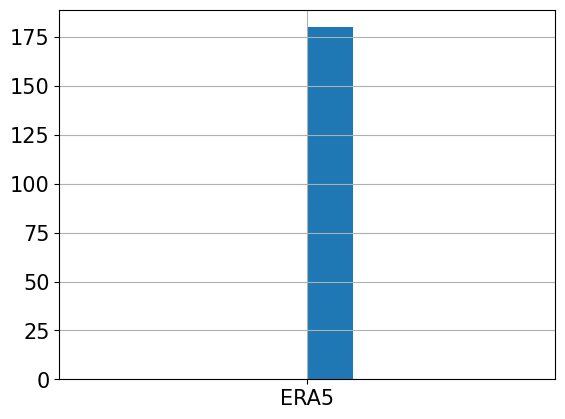

In [8]:
df_hyper['wind_source'].hist()

In [9]:
df_hyper.columns

Index(['plume_id', 'plume_latitude', 'plume_longitude', 'datetime', 'country',
       'state', 'city', 'name', 'ipcc_sector', 'gas', 'plume_bounds',
       'instrument', 'platform', 'provider', 'emission',
       'emission_uncertainty', 'emission_uncertainty_random',
       'emission_uncertainty_wind', 'emission_uncertainty_calibration',
       'emission_fetch', 'emission_fetch_uncertainty',
       'emission_fetch_uncertainty_ime', 'emission_fetch_uncertainty_wind',
       'emission_csf', 'emission_csf_uncertainty',
       'emission_csf_uncertainty_random', 'emission_csf_uncertainty_wind',
       'emission_csf_uncertainty_calibration', 'wind_source', 'wind_speed',
       'wind_direction', 'ime', 'ueff_ime', 'leff_ime', 'ueff_csf', 'l_csf',
       'alpha1', 'alpha2', 'alpha3', 'beta1', 'beta2', 'wind_speed_all',
       'wind_direction_all', 'wind_source_all', 'azimuth_diff_max', 'dist_max',
       'land_only', 'land_mask_source', 'emission_uncertainty(%)',
       'emission_fetch_uncerta

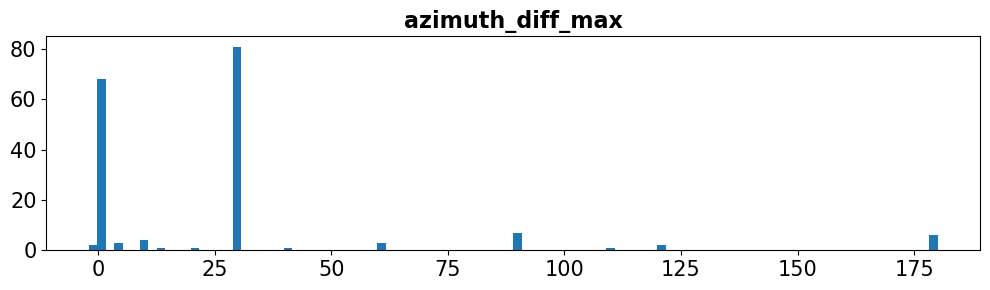

In [10]:
fig, axs = plt.subplots(figsize=(10, 3))

df_hyper.hist(column=['azimuth_diff_max'], ax=axs, bins=100)

fig.tight_layout()

axs.grid(False)

In [11]:
wspd_mean = df_hyper['wind_speed'].mean().round()

Q_min_emit = .03*0.01 * 3 * 60 * 5 * 3600 # precison(%)*backgroud(kg m-2) * U (m/s) * G (m) * q(5 for quantification)
Q_min_enmap = .05*0.01 * 3 * 30 * 5 * 3600
Q_min_prisma = .12*0.01 * 3 * 30 * 5 * 3600

Q_min_emit, Q_min_enmap, Q_min_prisma  # kg/h

(972.0000000000001, 809.9999999999999, 1944.0000000000002)

0.9028414682045374 1.1391240558805902 1.5196704326777446


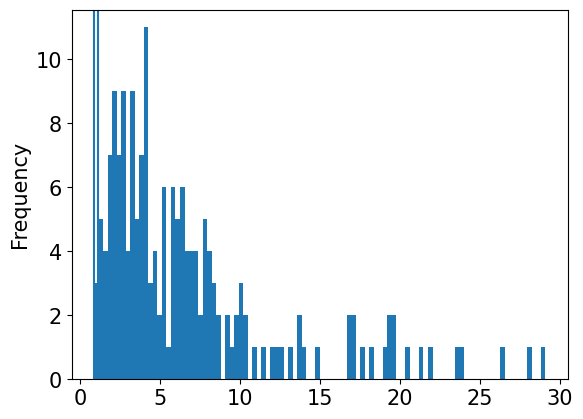

In [12]:
df_hyper['emission'].plot.hist(bins=100)
percent_1 = np.percentile(df_hyper['emission'], 1)
percent_5 = np.percentile(df_hyper['emission'], 5)
plt.axvline(x=df_hyper['emission'].min())
plt.axvline(x=percent_1)
print(df_hyper['emission'].min(), percent_1, percent_5)

In [13]:
df_hyper[df_hyper['emission']<=2][['emission', 'platform']]

,emission,platform
7,1.164062,EnMAP
16,1.465144,EnMAP
41,1.662913,EnMAP
42,1.768563,EnMAP
57,1.957210,EMIT
58,1.290322,EMIT
66,1.837809,EMIT
82,1.362634,EMIT
87,1.973991,EnMAP
89,0.902841,EnMAP


In [14]:
# low-emission detections
(df_hyper['emission']<1).sum(), ((df_hyper['emission']>1)&(df_hyper['emission']<2)).sum()

(1, 18)

## Comparison between ERA5 and GEOS-FP

In [15]:
wspd_era5 = np.array([i[0] for i in df_hyper['wind_speed_all']])
wspd_geosfp = np.array([i[1] for i in df_hyper['wind_speed_all']])

In [16]:
u_eff_era5 = df_hyper['alpha1'] * np.log(wspd_era5) + df_hyper['alpha2'] + df_hyper['alpha3'] * wspd_era5
u_eff_geosfp = df_hyper['alpha1'] * np.log(wspd_geosfp) + df_hyper['alpha2'] + df_hyper['alpha3'] * wspd_geosfp

Q_era5 = u_eff_era5 / df_hyper['leff_ime'] * df_hyper['ime'] * 3600 / 1e3  # t/h
Q_geosfp = u_eff_geosfp / df_hyper['leff_ime'] * df_hyper['ime'] * 3600 / 1e3  # t/h

In [17]:
df_hyper_geosfp = df_hyper.copy()
df_hyper_geosfp['emission'] = Q_geosfp

df_emiss_geosfp = df_hyper_geosfp.groupby(['country', 'name', 'platform'], as_index=False)\
    .agg({'plume_longitude':'mean', 'plume_latitude':'mean',
          'emission':'mean', 'emission_uncertainty(%)': 'mean',
          'emission_fetch': 'mean', 'emission_fetch_uncertainty(%)': 'mean',
          'plume_id': 'count', 'wind_speed': 'mean'}) \
    .rename(columns={'plume_id': 'plume_count'})

# remove space at end
df_emiss_geosfp['name'] = df_emiss_geosfp['name'].str.strip()

<Axes: >

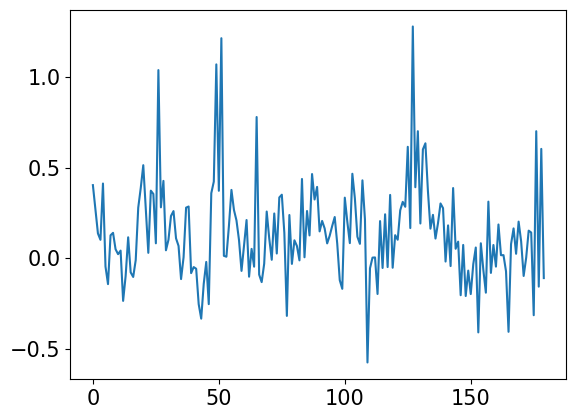

In [18]:
((Q_geosfp-Q_era5)/Q_era5).plot()

In [19]:
print('Mean percentage difference between Q_GEOSFP and Q_ERA5: ', ((Q_geosfp-Q_era5)/Q_era5).mean()*100)

Mean percentage difference between Q_GEOSFP and Q_ERA5:  13.935776851414394


0.5416438023192415


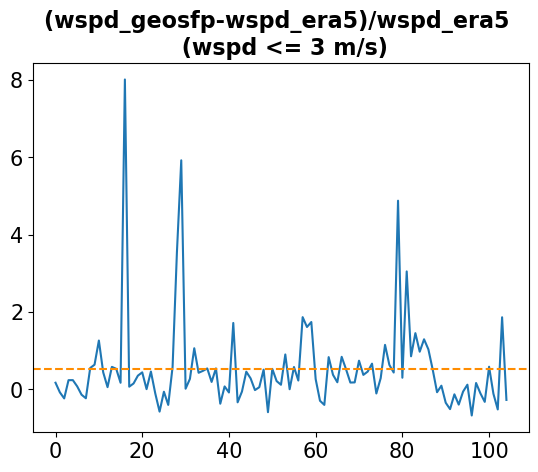

In [20]:
diff_highwspd = (wspd_geosfp[wspd_era5<=3]-wspd_era5[wspd_era5<=3])/wspd_era5[wspd_era5<=3]
plt.plot(diff_highwspd)
plt.title('(wspd_geosfp-wspd_era5)/wspd_era5 \n (wspd <= 3 m/s)')
plt.axhline(y=diff_highwspd.mean(), color='darkorange', linestyle='--')
print(diff_highwspd.mean())

0.43527665858013487


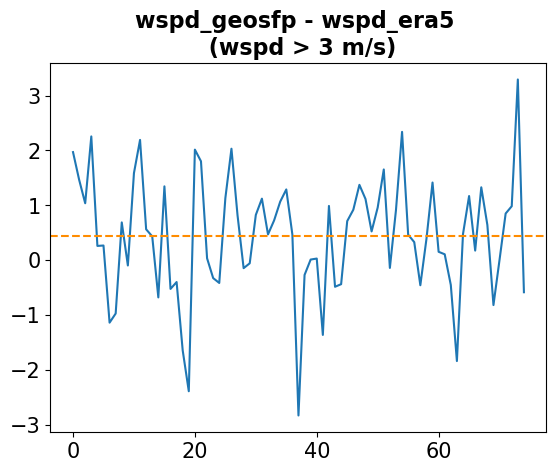

In [21]:
diff_lowwspd = wspd_geosfp[wspd_era5>3]-wspd_era5[wspd_era5>3]
plt.plot(diff_lowwspd, label='diff')
plt.title('wspd_geosfp - wspd_era5 \n (wspd > 3 m/s)')
plt.axhline(y=diff_lowwspd.mean(), color='darkorange', linestyle='--')
# plt.legend()
print(diff_lowwspd.mean())

We compare the ERA5 and GEOS-FP wind reanalysis data, and find that the error falls within the predefined wind error margin:

- uncertainty = 50%, if wspd <= 3 m/s
- uncertainty = 1.5 m/s, if wspd > 3 m/s

## Validate csv and excel files

In [22]:
def validate_name(df_emiss, df):
    csv_name = df_emiss['name'].drop_duplicates()
    excel_name = df['name'].drop_duplicates()
    name_valid = csv_name.isin(excel_name)
    if all(name_valid):
        print('All csv landfill names are in the excel file')
    else:
        print(csv_name[~name_valid], 'is not in the excel file')

def append_excel_data(row, df):
    count = df[df['name']==row['name']][f"plume({row['platform'].lower()})"].item()
    overpass = df[df['name']==row['name']][f"overpass({row['platform'].lower()})"].item()

    return int(count), int(overpass)

In [23]:
validate_name(df_emiss, df)

All csv landfill names are in the excel file


In [24]:
df_emiss['count'], df_emiss['overpass'] = zip(*df_emiss.apply(append_excel_data, args=(df,), axis=1))

# this should be empty
if ~df_emiss.query('plume_count != count').empty:
    print('If the DataFrame below is not empty, please make sure these landfill plume counts are same in Excel file and csv file.')
    print(df_emiss.query('plume_count != count'))

If the DataFrame below is not empty, please make sure these landfill plume counts are same in Excel file and csv file.
Empty DataFrame
Columns: [country, name, platform, plume_longitude, plume_latitude, emission, emission_uncertainty(%), emission_fetch, emission_fetch_uncertainty(%), plume_count, wind_speed, count, overpass]
Index: []


In [25]:
df_emiss_geosfp['count'], df_emiss_geosfp['overpass'] = zip(*df_emiss_geosfp.apply(append_excel_data, args=(df,), axis=1))

## Ratio of plume and overpass

In [26]:
df_emiss['ratio'] = df_emiss['plume_count']/df_emiss['overpass']

## Check CDF and source persistence

In [27]:
def plot_cdf(data, ax):
    # Fig 5 of https://www.pnas.org/doi/full/10.1073/pnas.1605617113

    # Step 1: Sort the emission data in descending order
    sorted_data = np.sort(data)[::-1]

    # Step 2: Calculate the cumulative sum of the sorted data
    cumulative_sum = np.cumsum(sorted_data)

    # Step 3: Calculate the percentile values for the emission data
    percentiles = np.linspace(0, 100, len(sorted_data))

    # Step 4: Plot the CDF of the summed fluxes against the flux percentiles
    ax.plot(percentiles, cumulative_sum / np.sum(sorted_data), '-', c='k')#, label='CDF')
    # ax.set_xlabel('Percentile (%) of Plumes (High to Low)')
    # ax.set_ylabel('Total Emission Pcercentage')
    # ax.axhline(y=0.6, c='darkgray', linestyle='--')
    # ax.hlines(y=0.4, xmin=0, xmax=15, color='darkgray', linestyle='--')

    # Step 5: Plot the emission at the respective percentiles as a red line
    ax2 = ax.twinx()
    ax2.plot(percentiles, sorted_data, '-', c='C0')#, label='Emission Rates')
    ax2.set_ylabel('Emission Rate (t h$^{-1}$)', c='C0')
    # ax2.hlines(y=9, xmin=20, xmax=100, color='darkgray', linestyle='--')
    # ax2.text(102, 9, 9, c='gray', size=font_size-2)

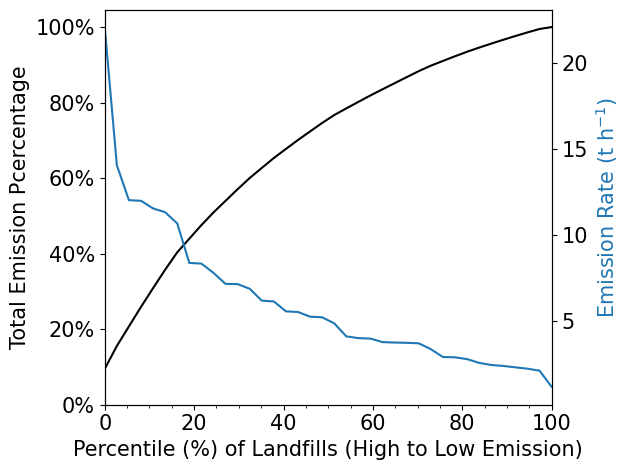

In [28]:
fig, axs = plt.subplots()

plot_cdf(df_emiss.groupby(['country', 'name'], as_index=False).agg({'emission':'mean'})['emission'],
         axs)

axs.set_xlabel('Percentile (%) of Landfills (High to Low Emission)')
axs.set_ylabel('Total Emission Pcercentage')
axs.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

# axs.axhline(y=0.45, c='darkgray', linestyle='--')
# axs.axvline(x=20, c='darkgray', linestyle='--')
axs.xaxis.set_minor_locator(AutoMinorLocator(4))

axs.set_ylim(ymin=0)
axs.set_xlim(xmin=0, xmax=100)

# plt.text(10, -2.2, 15, c='gray', size=font_size-2)

fig.tight_layout()
# fig.savefig('../figures/emission_cdf.pdf')

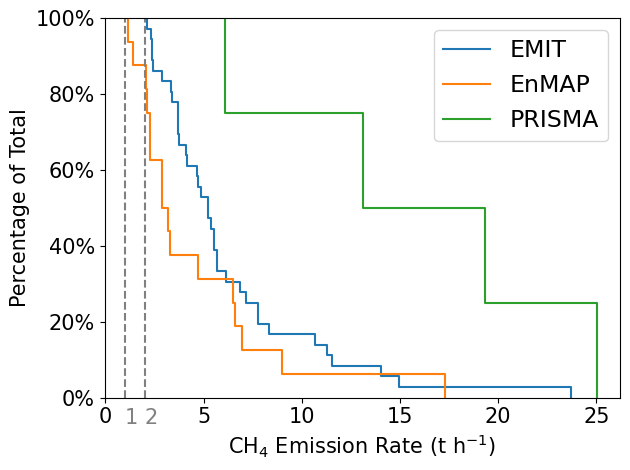

In [47]:
fig, axs = plt.subplots()

axs.ecdf(df_emiss[df_emiss['platform']=='EMIT']['emission'], label='EMIT', complementary=True)
axs.ecdf(df_emiss[df_emiss['platform']=='EnMAP']['emission'], label='EnMAP', complementary=True)
axs.ecdf(df_emiss[df_emiss['platform']=='PRISMA']['emission'], label='PRISMA', complementary=True)

axs.set_xlabel('CH$_4$ Emission Rate (t h$^{-1}$)')
axs.set_ylabel('Percentage of Total')
axs.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

# plt.axvline(x=df_emiss['emission'].min(), color='gray', linestyle='--')
# plt.text(df_emiss['emission'].min(), -0.07, np.round(df_emiss['emission'].min(), 2), c='gray', size=font_size-2)

plt.axvline(x=1, color='gray', linestyle='--')
plt.axvline(x=2, color='gray', linestyle='--')
plt.text(1, -0.07, 1, c='gray', size=font_size-2)
plt.text(2, -0.07, 2, c='gray', size=font_size-2)

plt.legend()
fig.tight_layout()
# fig.savefig('../figures/emission_cdf.pdf')

In [42]:
df_emit_enmap = df_emiss[df_emiss['platform'].isin(['EnMAP','EMIT'])]

df_emit_enmap_format = df_emit_enmap[df_emit_enmap['ratio']<1]
df_emit_enmap['emission_uncertainty'] = (df_emit_enmap['emission']*df_emit_enmap['emission_uncertainty(%)']*0.01)
df_emit_enmap = df_emit_enmap.round(decimals=1)
df_emit_enmap_format['Emission (t/h)'] = df_emit_enmap['emission'].astype(str) + ' $\pm$ ' + df_emit_enmap['emission_uncertainty'].astype(str)
print(df_emit_enmap_format[['country', 'name', 'platform', 'Emission (t/h)', 'plume_count', 'overpass']].to_latex(index=False))

\begin{tabular}{llllrr}
\toprule
country & name & platform & Emission (t/h) & plume_count & overpass \\
\midrule
India & Bandhwari & EMIT & 2.9 $\pm$ 1.1 & 2 & 3 \\
India & Deonar & EnMAP & 1.4 $\pm$ 0.6 & 1 & 2 \\
India & Okhla & EMIT & 2.3 $\pm$ 0.9 & 2 & 3 \\
Jordan & Al Akaider & EMIT & 5.7 $\pm$ 2.1 & 6 & 7 \\
Yemen & Al-Azraqin & EnMAP & 1.2 $\pm$ 0.4 & 1 & 2 \\
\bottomrule
\end{tabular}



/var/folders/n2/jdncdjcx465bv0ls_nyvsqx40000gn/T/ipykernel_55875/2781991692.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_emit_enmap['emission_uncertainty'] = (df_emit_enmap['emission']*df_emit_enmap['emission_uncertainty(%)']*0.01)


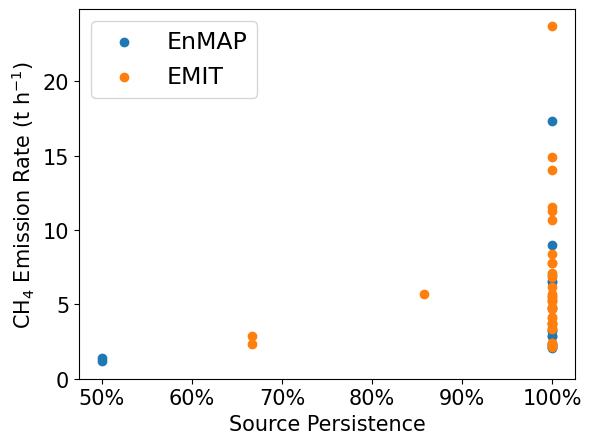

In [ ]:
fig, axs = plt.subplots()
plt.scatter(df_emiss[df_emiss['platform']=='EnMAP']['ratio'], df_emiss[df_emiss['platform']=='EnMAP']['emission'], label='EnMAP')
plt.scatter(df_emiss[df_emiss['platform']=='EMIT']['ratio'], df_emiss[df_emiss['platform']=='EMIT']['emission'], label='EMIT')
plt.xlabel('Source Persistence')
axs.xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.0%}'.format(x)))
plt.ylabel('CH$_4$ Emission Rate (t h$^{-1}$)')
plt.ylim(ymin=0)

plt.legend()

## Calculate mean emission and uncertainty

In [30]:
# assume 0 emission for no plume (only EMIT and EnMAP)
df_emiss['emission_mean'] = df_emiss['emission']*df_emiss['plume_count']/df_emiss['overpass']
df_emiss['emission_mean'] = np.where(df_emiss['platform'] == 'PRISMA', df_emiss['emission'], df_emiss['emission_mean'])

df_emiss['emission_ratio'] = df_emiss['emission_mean']/df_emiss['emission']

# duplicate for GEOS-FP data
df_emiss_geosfp['emission_mean'] = df_emiss_geosfp['emission']*df_emiss_geosfp['plume_count']/df_emiss_geosfp['overpass']
df_emiss_geosfp['emission_mean'] = np.where(df_emiss_geosfp['platform'] == 'PRISMA', df_emiss_geosfp['emission'], df_emiss_geosfp['emission_mean'])
df_emiss_geosfp['emission_fetch_mean'] = df_emiss_geosfp['emission_fetch']*df_emiss_geosfp['plume_count']/df_emiss_geosfp['overpass']
df_emiss_geosfp['emission_fetch_mean'] = np.where(df_emiss_geosfp['platform'] == 'PRISMA', df_emiss_geosfp['emission_fetch'], df_emiss_geosfp['emission_fetch_mean'])

df_emiss_geosfp['emission_ratio'] = df_emiss_geosfp['emission_mean']/df_emiss_geosfp['emission']

In [31]:
df_emiss

,country,name,platform,plume_longitude,plume_latitude,emission,emission_uncertainty(%),emission_fetch,emission_fetch_uncertainty(%),plume_count,wind_speed,count,overpass,ratio,emission_mean,emission_ratio
0,Argentina,González Catán,EMIT,-58.665726,-34.784165,3.397676,38.305478,3.913084,52.903088,3,2.541348,3,3,1.000000,3.397676,1.000000
1,Argentina,González Catán,EnMAP,-58.667353,-34.785561,2.141890,29.913619,3.354491,51.299637,2,3.393430,2,2,1.000000,2.141890,1.000000
2,Argentina,Norte III,EMIT,-58.623094,-34.527867,23.723598,33.727829,23.267240,52.287814,4,2.889840,4,4,1.000000,23.723598,1.000000
3,Argentina,Norte III,EnMAP,-58.628153,-34.527236,17.298987,25.230443,8.885399,37.911145,2,4.510046,2,2,1.000000,17.298987,1.000000
4,Argentina,Norte III,PRISMA,-58.626461,-34.526585,25.012967,28.724630,26.701701,49.467078,2,3.078821,2,2,1.000000,25.012967,1.000000
5,Argentina,Piedra Blanca,EMIT,-64.235391,-31.519801,3.347987,38.834970,4.095623,45.734736,2,3.919701,2,2,1.000000,3.347987,1.000000
6,Bangladesh,Aminbazar,EMIT,90.298762,23.797924,4.092617,39.811138,2.766372,46.674243,1,3.373145,1,1,1.000000,4.092617,1.000000
7,Brazil,Caieiras,EMIT,-46.771954,-23.346724,14.035058,34.313487,17.278768,53.892568,1,2.467657,1,1,1.000000,14.035058,1.000000
8,Brazil,Pedreira,EMIT,-46.560783,-23.403698,11.525591,34.654589,11.780466,51.220530,1,2.598492,1,1,1.000000,11.525591,1.000000
9,China,Ürümqi,EMIT,87.865135,44.038444,10.652942,41.183351,6.454128,50.650664,5,2.013745,5,5,1.000000,10.652942,1.000000


Text(0.5, 0, 'Landfills')

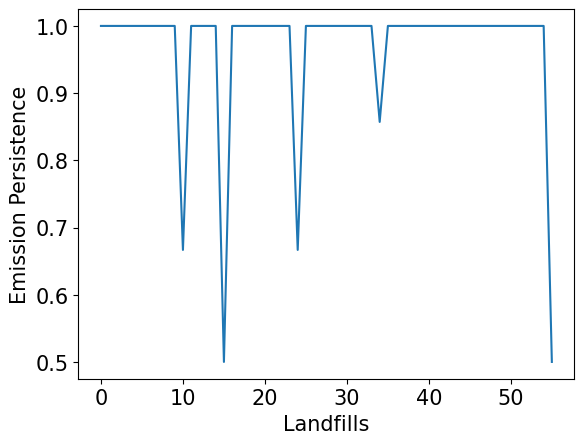

In [32]:
# df_emiss[df_emiss['platform'].isin(['EnMAP', 'EMIT'])].sort_values('emission_ratio')[['country', 'name', 'emission', 'emission_mean','emission_ratio', 'plume_count', 'overpass']]
df_emiss[df_emiss['platform'].isin(['EnMAP', 'EMIT'])]['emission_ratio'].plot()
plt.ylabel('Emission Persistence')
plt.xlabel('Landfills')

## Merge into one csv file

In [33]:
df_summary = df_emiss[['country', 'name', 'platform', 'plume_latitude', 'plume_longitude',
          'emission_mean', 'emission_uncertainty(%)', 'plume_count', 'overpass', 'wind_speed']]\
            .rename(columns={'plume_latitude': 'latitude', 'plume_longitude': 'longitude', 'emission_mean': 'emission'})
df_summary = df_summary.merge(df[['name', 'emissions_quantity', 'emissions_factor', 'capacity', 'activity', 'metadata_source', 'metadata_report_year']], on='name', how='left')

In [34]:
df_summary

,country,name,platform,latitude,longitude,emission,emission_uncertainty(%),plume_count,overpass,wind_speed,emissions_quantity,emissions_factor,capacity,activity,metadata_source,metadata_report_year
0,Argentina,González Catán,EMIT,-34.784165,-58.665726,3.397676,38.305478,3,3,2.541348,19079.02,0.041004,1200000.00,465297.85,Waste Atlas,2013.0
1,Argentina,González Catán,EnMAP,-34.785561,-58.667353,2.141890,29.913619,2,2,3.393430,19079.02,0.041004,1200000.00,465297.85,Waste Atlas,2013.0
2,Argentina,Norte III,EMIT,-34.527867,-58.623094,23.723598,33.727829,4,4,2.889840,28528.14,0.045643,900000.00,625026.97,Waste Atlas,2013.0
3,Argentina,Norte III,EnMAP,-34.527236,-58.628153,17.298987,25.230443,2,2,4.510046,28528.14,0.045643,900000.00,625026.97,Waste Atlas,2013.0
4,Argentina,Norte III,PRISMA,-34.526585,-58.626461,25.012967,28.724630,2,2,3.078821,28528.14,0.045643,900000.00,625026.97,Waste Atlas,2013.0
5,Argentina,Piedra Blanca,EMIT,-31.519801,-64.235391,3.347987,38.834970,2,2,3.919701,14902.44,0.041850,NaN,356094.72,METER/OSM,2022.0
6,Bangladesh,Aminbazar,EMIT,23.797924,90.298762,4.092617,39.811138,1,1,3.373145,13506.95,0.046725,NaN,289072.51,METER/OSM,2022.0
7,Brazil,Caieiras,EMIT,-23.346724,-46.771954,14.035058,34.313487,1,1,2.467657,NaN,NaN,NaN,NaN,NaN,NaN
8,Brazil,Pedreira,EMIT,-23.403698,-46.560783,11.525591,34.654589,1,1,2.598492,NaN,NaN,NaN,NaN,NaN,NaN
9,China,Ürümqi,EMIT,44.038444,87.865135,10.652942,41.183351,5,5,2.013745,NaN,NaN,NaN,NaN,NaN,NaN


In [35]:
df_summary[df_summary['platform']=='PRISMA']

,country,name,platform,latitude,longitude,emission,emission_uncertainty(%),plume_count,overpass,wind_speed,emissions_quantity,emissions_factor,capacity,activity,metadata_source,metadata_report_year
4,Argentina,Norte III,PRISMA,-34.526585,-58.626461,25.012967,28.724630,2,2,3.078821,28528.14,0.045643,900000.00,625026.97,Waste Atlas,2013.0
21,India,Kanjurmarg,PRISMA,19.123811,72.952129,13.114379,30.260846,2,2,1.692903,3872.44,0.050050,38354.50,77371.17,Global Plastic Watch,2021.0
27,India,Pirana,PRISMA,22.982893,72.570045,6.075245,33.785852,5,28,2.064798,19285.05,0.048327,649995.49,399053.89,Waste Atlas,2013.0
46,Pakistan,Lakhodair,PRISMA,31.625778,74.420998,19.331678,31.003526,1,2,2.138016,NaN,NaN,NaN,NaN,NaN,NaN


In [36]:
df_summary_geosfp = df_emiss_geosfp[['country', 'name', 'platform', 'plume_latitude', 'plume_longitude',
          'emission_mean', 'emission_uncertainty(%)', 'emission_fetch_mean', 'emission_fetch_uncertainty(%)', 'plume_count', 'overpass', 'wind_speed']]\
            .rename(columns={'plume_latitude': 'latitude', 'plume_longitude': 'longitude', 'emission_mean': 'emission', 'emission_fetch_mean': 'emission_fetch'})
df_summary_geosfp = df_summary_geosfp.merge(df[['name', 'emissions_quantity', 'emissions_factor', 'capacity', 'activity', 'metadata_source', 'metadata_report_year']], on='name', how='left')

In [37]:
df_summary.to_csv('../data/landfills_hyper_summary.csv', index=False)
df_summary_geosfp.to_csv('../data/landfills_hyper_summary_geosfp.csv', index=False)

In [38]:
df_summary['null detections'] = (df_summary['overpass'] - df_summary['plume_count'])
df_summary['null detections'][df_summary['platform']=='PRISMA'] = 0

/var/folders/n2/jdncdjcx465bv0ls_nyvsqx40000gn/T/ipykernel_81773/1879187809.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_summary['null detections'][df_summary['platform']=='PRISMA'] = 0


In [39]:
df_emiss = df_summary.groupby(['country', 'name'], as_index=False)\
    .agg({'emission':'mean', 'emission_uncertainty(%)': 'mean', 'latitude': 'mean', 'longitude': 'mean', 'plume_count': 'sum', 'null detections': 'sum'})

df_emiss['null detections'][df_emiss['null detections']==0] = np.nan

df_emiss = df_emiss[['country', 'name', 'latitude', 'longitude', 'plume_count', 'null detections',
            'emission',	'emission_uncertainty(%)',
            ]]\
                .rename(columns={'country': 'Country', 'name': 'Landfill Name',
                                 'latitude': 'Latitude', 'longitude': 'Longitude',
                                 'emission': 'Emission (t/h)', 'emission_uncertainty(%)': 'Uncertainty (%)',
                                 'plume_count': 'Plume Counts', 'null detections': 'Null Detections',
                                 }
                        )

df_emiss['Uncertainty (t/h)'] = df_emiss['Emission (t/h)'] * df_emiss['Uncertainty (%)'] * 1e-2
# move to the last column
df_emiss['Uncertainty (%)'] = df_emiss.pop('Uncertainty (%)')

/var/folders/n2/jdncdjcx465bv0ls_nyvsqx40000gn/T/ipykernel_81773/1785169083.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_emiss['null detections'][df_emiss['null detections']==0] = np.nan


In [40]:
df_emiss

,Country,Landfill Name,Latitude,Longitude,Plume Counts,Null Detections,Emission (t/h),Uncertainty (t/h),Uncertainty (%)
0,Argentina,González Catán,-34.784863,-58.666540,5,NaN,2.769783,0.944760,34.109548
1,Argentina,Norte III,-34.527229,-58.625903,8,NaN,22.011851,6.433543,29.227634
2,Argentina,Piedra Blanca,-31.519801,-64.235391,2,NaN,3.347987,1.300190,38.834970
3,Bangladesh,Aminbazar,23.797924,90.298762,1,NaN,4.092617,1.629317,39.811138
4,Brazil,Caieiras,-23.346724,-46.771954,1,NaN,14.035058,4.815918,34.313487
5,Brazil,Pedreira,-23.403698,-46.560783,1,NaN,11.525591,3.994146,34.654589
6,China,Ürümqi,44.038444,87.865135,5,NaN,10.652942,4.387238,41.183351
7,India,Bandhwari,28.402066,77.171672,4,1.0,2.397993,0.823099,34.324486
8,India,Bhalswa,28.741783,77.156479,6,NaN,2.214972,0.795131,35.898002
9,India,Deonar,19.072748,72.928466,2,1.0,2.199969,0.944221,42.919733


In [41]:
# df_merge_ct_format = df_merge_ct.round(decimals=1)
# df_merge_ct_format['HSI'] = df_merge_ct_format['HSI'].astype(str) + ' $\pm$ ' + df_merge_ct_format['HSI uncertainty (t h$^{-1}$)'].astype(str)
# # # print latex table
# print(df_merge_ct_format.drop('HSI uncertainty (t h$^{-1}$)', axis=1).to_latex(index=False, float_format=lambda x: '%10.1f' % x))

In [42]:
df_emiss_format = df_emiss.round(decimals=1)
df_emiss_format['Emission (t/h)'] = df_emiss_format['Emission (t/h)'].astype(str) + ' $\pm$ ' + df_emiss_format['Uncertainty (t/h)'].astype(str)
df_emiss_format['Latitude'] = df_emiss['Latitude'].round(4).astype(str)
df_emiss_format['Longitude'] = df_emiss['Longitude'].round(4).astype(str)
df_emiss_format['Uncertainty (%)'] = df_emiss['Uncertainty (%)'].round(1).astype(str)
# df_emiss_format['Null Detections'] = df_emiss['Null Detections'].round(1).astype(str)
print(df_emiss_format.drop('Uncertainty (t/h)', axis=1).fillna('-').to_latex(index=False))

\begin{tabular}{llllrlll}
\toprule
Country & Landfill Name & Latitude & Longitude & Plume Counts & Null Detections & Emission (t/h) & Uncertainty (%) \\
\midrule
Argentina & González Catán & -34.7849 & -58.6665 & 5 & - & 2.8 $\pm$ 0.9 & 34.1 \\
Argentina & Norte III & -34.5272 & -58.6259 & 8 & - & 22.0 $\pm$ 6.4 & 29.2 \\
Argentina & Piedra Blanca & -31.5198 & -64.2354 & 2 & - & 3.3 $\pm$ 1.3 & 38.8 \\
Bangladesh & Aminbazar & 23.7979 & 90.2988 & 1 & - & 4.1 $\pm$ 1.6 & 39.8 \\
Brazil & Caieiras & -23.3467 & -46.772 & 1 & - & 14.0 $\pm$ 4.8 & 34.3 \\
Brazil & Pedreira & -23.4037 & -46.5608 & 1 & - & 11.5 $\pm$ 4.0 & 34.7 \\
China & Ürümqi & 44.0384 & 87.8651 & 5 & - & 10.7 $\pm$ 4.4 & 41.2 \\
India & Bandhwari & 28.4021 & 77.1717 & 4 & 1.000000 & 2.4 $\pm$ 0.8 & 34.3 \\
India & Bhalswa & 28.7418 & 77.1565 & 6 & - & 2.2 $\pm$ 0.8 & 35.9 \\
India & Deonar & 19.0727 & 72.9285 & 2 & 1.000000 & 2.2 $\pm$ 0.9 & 42.9 \\
India & Ghazipur & 28.6237 & 77.3277 & 9 & - & 4.0 $\pm$ 1.3 & 33.7 \\
In

In [43]:
# print(df_emiss.style.format(lambda x: '%10.4f' % x, subset=['Latitude', 'Longitude'])\
#     .format(lambda x: '%10.1f' % x, subset=['Emission (t/h)', 'Uncertainty (t/h)', 'Uncertainty (%)'])\
#     .hide(axis="index").to_latex()
# )

In [44]:
# print(df_emiss.to_latex(index=False, float_format=lambda x: '%10.1f' % x))

In [45]:
df_emiss_country = df_emiss.groupby(['Country'], as_index=False)\
    .agg({'Emission (t/h)': 'sum',
          'Uncertainty (t/h)': lambda x: np.sqrt(sum(x**2)),
          })
df_emiss_country['Uncertainty (%)'] = df_emiss_country['Uncertainty (t/h)'] / df_emiss_country['Emission (t/h)']  * 1e2
# df_emiss_country['Uncertainty (t/h)'] = df_emiss_country['Emission (t/h)'] * df_emiss_country['Uncertainty (%)'] * 1e-2

In [46]:
df_emiss_country

,Country,Emission (t/h),Uncertainty (t/h),Uncertainty (%)
0,Argentina,28.129621,6.631255,23.573923
1,Bangladesh,4.092617,1.629317,39.811138
2,Brazil,25.560648,6.256698,24.477852
3,China,10.652942,4.387238,41.183351
4,India,41.438584,5.015747,12.104050
5,Iran,11.499941,3.241336,28.185671
6,Israel,11.370299,2.745100,24.142721
7,Jordan,11.941727,2.718958,22.768550
8,Kuwait,7.129995,2.145553,30.091927
9,Mexico,23.721206,5.297018,22.330306


In [47]:
print('Total CH4 emission (t/h): ', df_emiss_country['Emission (t/h)'].sum(),
      ', uncertainty (t/h): ', np.sqrt(sum(df_emiss_country['Uncertainty (t/h)']**2))
)

Total CH4 emission (t/h):  229.4930933590738 , uncertainty (t/h):  15.42239252184485


In [48]:
# print(df_emiss_country.to_latex(index=False, float_format=lambda x: '%10.1f' % x))

In [49]:
df_emiss_country_format = df_emiss_country.round(decimals=1)
df_emiss_country_format['Emission (t/h)'] = df_emiss_country_format['Emission (t/h)'].astype(str) + ' $\pm$ ' + df_emiss_country_format['Uncertainty (t/h)'].astype(str)
# # print latex table
print(df_emiss_country_format.drop('Uncertainty (t/h)', axis=1).to_latex(index=False, float_format=lambda x: '%10.1f' % x))

\begin{tabular}{llr}
\toprule
Country & Emission (t/h) & Uncertainty (%) \\
\midrule
Argentina & 28.1 $\pm$ 6.6 &       23.6 \\
Bangladesh & 4.1 $\pm$ 1.6 &       39.8 \\
Brazil & 25.6 $\pm$ 6.3 &       24.5 \\
China & 10.7 $\pm$ 4.4 &       41.2 \\
India & 41.4 $\pm$ 5.0 &       12.1 \\
Iran & 11.5 $\pm$ 3.2 &       28.2 \\
Israel & 11.4 $\pm$ 2.7 &       24.1 \\
Jordan & 11.9 $\pm$ 2.7 &       22.8 \\
Kuwait & 7.1 $\pm$ 2.1 &       30.1 \\
Mexico & 23.7 $\pm$ 5.3 &       22.3 \\
Pakistan & 17.2 $\pm$ 4.6 &       26.6 \\
Saudi Arabia & 12.0 $\pm$ 3.4 &       28.5 \\
Spain & 7.1 $\pm$ 2.5 &       35.0 \\
Tunisia & 5.5 $\pm$ 2.0 &       35.9 \\
United States & 7.7 $\pm$ 2.2 &       28.0 \\
Uzbekistan & 3.7 $\pm$ 1.4 &       37.1 \\
Yemen & 0.6 $\pm$ 0.2 &       33.2 \\
\bottomrule
\end{tabular}

